# Load Data

In [40]:
# Libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


import librosa
import librosa.display
from IPython.display import Audio
from skimage import color

from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, AutoConfig

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from scipy.special import softmax

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, BatchNormalization, Dropout

In [41]:
# Loading data from csv
df = pd.read_csv('Sarcasm_Model_Dataset.csv')
df.head()

# Splitting data into test and train (80:20 split)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)
# print(len(train_df))

Visual Classifier
--

In [42]:


train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

#Create Directories for training images
output_dir = 'train_images'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

columns_to_iterate = ['frame_1', 'frame_2', 'frame_3']

# Iterate through each column
for column in columns_to_iterate:
    # Create a directory for the current column if it doesn't exist
    column_dir = os.path.join(output_dir, column)
    if not os.path.exists(column_dir):
        os.makedirs(column_dir)
        
    sarcastic = os.path.join(column_dir, 'sarcastic')    
    not_sarcastic = os.path.join(column_dir, 'not_sarcastic')
    if not os.path.exists(sarcastic):
        os.makedirs(sarcastic)
    if not os.path.exists(not_sarcastic):
        os.makedirs(not_sarcastic)
        
    for i in range(len(train_df)): 
        pixel_values = np.array(train_df[column][i].split(), dtype=np.uint8)
        
        # Reshape pixel values into image dimensions
        image_array = pixel_values.reshape((48,48,1))
        image_array = np.repeat(image_array, 3, axis=2)
        # Create a PIL Image object
        image = Image.fromarray(image_array)
        
        if train_df['sarcasm'][i] == True:
            save_dir = sarcastic
        else:
            save_dir = not_sarcastic
        image.save(os.path.join(save_dir, f'image_{i}.png'))  # Assuming you want to save images as PNG files

In [43]:
#Create Directories for test images
output_dir = 'test_images'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

columns_to_iterate = ['frame_1', 'frame_2', 'frame_3']

# Iterate through each column
for column in columns_to_iterate:
    # Create a directory for the current column if it doesn't exist
    column_dir = os.path.join(output_dir, column)
    if not os.path.exists(column_dir):
        os.makedirs(column_dir)
    
    sarcastic = os.path.join(column_dir, 'sarcastic')    
    not_sarcastic = os.path.join(column_dir, 'not_sarcastic')
    if not os.path.exists(sarcastic):
        os.makedirs(sarcastic)
    if not os.path.exists(not_sarcastic):
        os.makedirs(not_sarcastic)

    for i in range(len(test_df)): 
        pixel_values = np.array(test_df[column][i].split(), dtype=np.uint8)
        
        # Reshape pixel values into image dimensions
        image_array = pixel_values.reshape((48,48,1))
        image_array = np.repeat(image_array, 3, axis=2)
        
        # Create a PIL Image object
        image = Image.fromarray(image_array)

        if train_df['sarcasm'][i] == True:
            save_dir = sarcastic
        else:
            save_dir = not_sarcastic
            
        image.save(os.path.join(save_dir, f'image_{i}.png'))  # Assuming you want to save images as PNG files

In [44]:
#Create generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator_f1 = train_datagen.flow_from_directory(
    'train_images/frame_1/',
    target_size=(48,48),
    batch_size=32,
    class_mode='binary',
    classes=['sarcastic', 'not_sarcastic']
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator_f1 = test_datagen.flow_from_directory(
    'test_images/frame_1/',
    target_size=(48, 48),
    batch_size=32,
    class_mode='binary',
    classes=['sarcastic', 'not_sarcastic'],
    shuffle=False
)

Found 168 images belonging to 2 classes.
Found 42 images belonging to 2 classes.


In [45]:
# Training parameters
n_epochs = 15

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48,48, 3))

# Add custom classifier layers on top of ResNet50
x = base_model.output
#x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Flatten()(x)
output = Dense(1, activation='sigmoid')(x)

# Create the full model
resnet_model = Model(inputs=base_model.input, outputs=output)

# Freeze layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model (assumes you have train and validation generators)
history = resnet_model.fit(train_generator_f1, epochs=n_epochs)

Epoch 1/15
6/6 [==============================] - 13s 426ms/step - loss: 0.7921 - accuracy: 0.5417
Epoch 2/15
6/6 [==============================] - 2s 234ms/step - loss: 0.7755 - accuracy: 0.5179
Epoch 3/15
6/6 [==============================] - 1s 220ms/step - loss: 0.8100 - accuracy: 0.4881
Epoch 4/15
6/6 [==============================] - 2s 220ms/step - loss: 0.7536 - accuracy: 0.4881
Epoch 5/15
6/6 [==============================] - 2s 226ms/step - loss: 0.7151 - accuracy: 0.5119
Epoch 6/15
6/6 [==============================] - 1s 215ms/step - loss: 0.7775 - accuracy: 0.4643
Epoch 7/15
6/6 [==============================] - 2s 222ms/step - loss: 0.7777 - accuracy: 0.5298
Epoch 8/15
6/6 [==============================] - 2s 225ms/step - loss: 0.7370 - accuracy: 0.5060
Epoch 9/15
6/6 [==============================] - 2s 263ms/step - loss: 0.7619 - accuracy: 0.5119
Epoch 10/15
6/6 [==============================] - 2s 224ms/step - loss: 0.7511 - accuracy: 0.5119
Epoch 11/15
6/6 [=

In [46]:
# Output the accuracy
visual_loss, visual_accuracy = resnet_model.evaluate(test_generator_f1)

print("Test Accuracy:", visual_accuracy)

2/2 [==============================] - 3s 109ms/step - loss: 0.6944 - accuracy: 0.5714
Test Accuracy: 0.5714285969734192


In [47]:
# Perform inference on test images
visual_predictions = resnet_model.predict(test_generator_f1)

# Output the percentage that each image is sarcastic
print(visual_predictions)

2/2 [==============================] - 4s 117ms/step
[[0.49843055]
 [0.43217582]
 [0.4959605 ]
 [0.4657651 ]
 [0.366039  ]
 [0.4009132 ]
 [0.34052154]
 [0.4386709 ]
 [0.45657828]
 [0.41229218]
 [0.4506959 ]
 [0.44241846]
 [0.4125816 ]
 [0.3920646 ]
 [0.44546998]
 [0.4162069 ]
 [0.44317317]
 [0.4927784 ]
 [0.42275655]
 [0.47074363]
 [0.4985928 ]
 [0.4715255 ]
 [0.4792515 ]
 [0.4747015 ]
 [0.41227373]
 [0.5285966 ]
 [0.45446014]
 [0.40067804]
 [0.38097873]
 [0.39075837]
 [0.43497887]
 [0.43703607]
 [0.50132304]
 [0.47805992]
 [0.4585438 ]
 [0.3812153 ]
 [0.4377294 ]
 [0.46401986]
 [0.50111765]
 [0.38778856]
 [0.4517801 ]
 [0.45446077]]


# Audio Classifier

In [49]:
#Sources: https://medium.com/@hasithsura/audio-classification-d37a82d6715
         #https://github.com/jeffprosise/Deep-Learning/blob/master/Audio%20Classification%20(CNN).ipynb

#Define helper functions
max_audio_length = 10 #seconds

def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<max_audio_length*sr:
    wav=np.pad(wav,int(np.ceil((max_audio_length*sr-wav.shape[0])/2)),mode='reflect') #pad audio by reflecting
  else:
    wav=wav[:max_audio_length*sr]
  spec=librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=n_fft, hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps) #z score normalization
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [50]:
#Convert .wav files to spectrogram images
audio_dir = 'audio_data'

def get_spec_images(filenames, directory):
    spec_images = []
    for filename in filenames:
        if filename.endswith(".wav"):
            file_path = os.path.join(directory, filename)
            spectrogram = get_melspectrogram_db(file_path)
            spec_image = spec_to_image(spectrogram)
            spec_images.append(spec_image)
    return spec_images

train_spec_images = get_spec_images(train_df['tone'], audio_dir)
train_spec_labels = train_df['sarcasm']

test_spec_images = get_spec_images(test_df['tone'], audio_dir)
test_spec_labels = test_df['sarcasm']

In [51]:
#divide the pixel values by 255
tone_train_norm = np.array(train_spec_images) 
tone_test_norm = np.array(test_spec_images)

#one-hot-encode the labels
tone_train_encoded = to_categorical(train_spec_labels)
tone_test_encoded = to_categorical(test_spec_labels)

In [52]:
#Build Model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 862, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='sigmoid'))  # Output layer with 1 unit for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()

In [53]:
batch = 10
epochs = 10

#Fit the model
tone_model = model.fit(tone_train_norm, tone_train_encoded, batch_size=batch, epochs=epochs, validation_split = 0.2)

Epoch 1/10
14/14 [==============================] - 46s 3s/step - loss: 57.4016 - accuracy: 0.5149 - val_loss: 23.2997 - val_accuracy: 0.5294
Epoch 2/10
14/14 [==============================] - 34s 2s/step - loss: 16.8159 - accuracy: 0.6493 - val_loss: 5.1144 - val_accuracy: 0.4412
Epoch 3/10
14/14 [==============================] - 33s 2s/step - loss: 2.4348 - accuracy: 0.8433 - val_loss: 12.0693 - val_accuracy: 0.4706
Epoch 4/10
14/14 [==============================] - 33s 2s/step - loss: 0.5184 - accuracy: 0.8881 - val_loss: 9.1634 - val_accuracy: 0.4118
Epoch 5/10
14/14 [==============================] - 33s 2s/step - loss: 0.5820 - accuracy: 0.8806 - val_loss: 9.3069 - val_accuracy: 0.4412
Epoch 6/10
14/14 [==============================] - 34s 2s/step - loss: 0.9272 - accuracy: 0.8582 - val_loss: 7.0174 - val_accuracy: 0.6176
Epoch 7/10
14/14 [==============================] - 35s 2s/step - loss: 0.7090 - accuracy: 0.8806 - val_loss: 8.3252 - val_accuracy: 0.5882
Epoch 8/10
14/14

[]

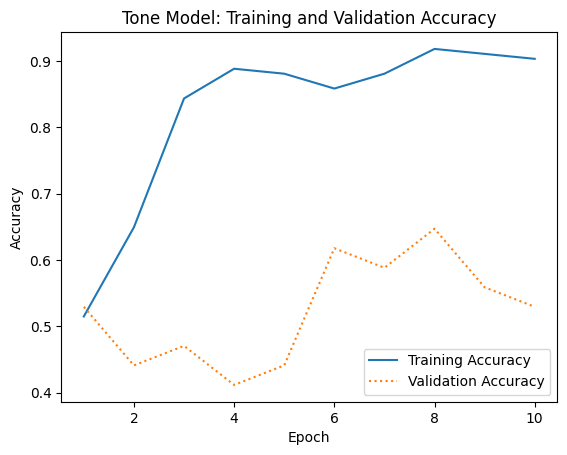

In [54]:
#Train and validation accuracy graph
accuracy = tone_model.history['accuracy']
validation_acc = tone_model.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, '-', label='Training Accuracy')
plt.plot(epochs, validation_acc, ':', label='Validation Accuracy')
plt.title('Tone Model: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [55]:
#make predictions on test set
tone_predictions = model.predict(tone_test_norm)

#Filter to only positive class
tone_predictions = tone_predictions[:, 1]
print(tone_predictions)

2/2 [==============================] - 2s 482ms/step
[5.0835067e-01 5.0835067e-01 6.4819507e-02 5.0835067e-01 7.2744304e-01
 1.0000000e+00 4.2687026e-07 3.4432450e-01 9.9896348e-01 9.9992919e-01
 5.0835067e-01 9.9335086e-01 2.4579669e-05 9.9999899e-01 2.2961356e-01
 7.9337436e-01 1.4448425e-04 9.9999982e-01 0.0000000e+00 8.7505448e-01
 5.0835067e-01 5.0835067e-01 3.5214770e-01 0.0000000e+00 9.9974740e-01
 5.0835067e-01 1.2669337e-01 3.8248457e-23 9.9999881e-01 5.5800206e-06
 1.0000000e+00 1.0000000e+00 5.0835067e-01 5.0835067e-01 4.4965917e-01
 9.9822682e-01 2.2457169e-01 9.9897200e-01 5.0835067e-01 9.4342613e-01
 9.9995863e-01 1.0000000e+00]


# Text Classifer

In [56]:
# Load sentiment classifier
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

# Classify text and add sentiment and score columns to DataFrame
def classify_text(row):
    text = row['text']
    encoded_input = tokenizer(text, return_tensors='tf')
    output = model(**encoded_input)
    scores = output[0][0].numpy()  # Convert TensorFlow tensor to NumPy array
    scores = softmax(scores)
    ranking = np.argsort(scores)[::-1]
    l = config.id2label[ranking[0]]  # Take the label with highest score
    s = np.round(float(scores[ranking[0]]), 4)
    return pd.Series({'sentiment': l, 'score': s})

# Apply classifier to each row in the DataFrame
train_df[['sentiment', 'sentiment_score']] = train_df.apply(classify_text, axis=1)
test_df[['sentiment', 'sentiment_score']] = test_df.apply(classify_text, axis=1)

# Display the DataFrame with new columns
print(train_df.head())
print(test_df.head())

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


         video                                            frame_1  \
0    2_208.mp4  8 8 8 8 8 6 6 6 6 6 7 7 7 6 6 6 5 4 9 23 14 13...   
1    2_575.mp4  8 8 6 3 8 12 14 33 44 58 54 24 37 29 35 38 38 ...   
2    1_276.mp4  123 124 124 92 31 11 14 15 15 16 15 15 15 13 1...   
3  1_10890.mp4  53 58 63 44 59 155 169 168 167 164 163 161 161...   
4    2_514.mp4  72 97 132 169 162 136 81 155 191 175 194 195 2...   

                                             frame_2  \
0  2 2 2 2 2 2 3 3 3 3 3 2 3 2 1 17 20 14 15 15 1...   
1  2 1 5 15 20 19 13 30 49 33 23 32 33 29 24 29 2...   
2  93 30 3 4 5 6 5 5 6 6 6 7 7 7 9 5 4 4 6 4 2 5 ...   
3  59 57 33 59 70 39 40 46 148 166 161 163 164 16...   
4  181 195 222 197 178 210 230 248 230 105 13 15 ...   

                                             frame_3         tone  \
0  6 6 6 7 7 7 8 8 7 6 6 7 7 7 7 7 7 9 7 6 7 9 9 ...    2_208.wav   
1  14 13 3 1 10 21 19 14 38 42 34 27 45 42 30 26 ...    2_575.wav   
2  123 96 29 3 4 5 6 6 6 5 6 6 7 8 8 5 3 

In [57]:
# Encode labels
label_encoder = LabelEncoder()
train_df['sarcasm_encoded'] = label_encoder.fit_transform(train_df['sarcasm'])
test_df['sarcasm_encoded'] = label_encoder.fit_transform(test_df['sarcasm'])

# Text preprocessing
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_text_train = tfidf_vectorizer.fit_transform(train_df['text']).toarray()
X_text_test = tfidf_vectorizer.transform(test_df['text']).toarray()

# Convert sentiment labels to numerical values
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
train_df['sentiment_encoded'] = train_df['sentiment'].map(sentiment_mapping)
test_df['sentiment_encoded'] = test_df['sentiment'].map(sentiment_mapping)

# Combine text features with sentiment scores
X_train = np.concatenate((X_text_train, train_df[['sentiment_encoded', 'sentiment_score']].values), axis=1)
y_train = train_df['sarcasm_encoded']
X_test = np.concatenate((X_text_test, test_df[['sentiment_encoded', 'sentiment_score']].values), axis=1)
y_test = test_df['sarcasm_encoded']

In [58]:
# Training parameters
n_epochs = 12
n_batch = 15

# Define neural network architecture
text_model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
text_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
text_model.fit(X_train, y_train, batch_size=n_batch, epochs=n_epochs, validation_split=0.2)

# Evaluate the model
loss, accuracy = text_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/12
9/9 [==============================] - 3s 49ms/step - loss: 0.6917 - accuracy: 0.5224 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 2/12
9/9 [==============================] - 0s 9ms/step - loss: 0.6778 - accuracy: 0.6866 - val_loss: 0.6937 - val_accuracy: 0.4706
Epoch 3/12
9/9 [==============================] - 0s 9ms/step - loss: 0.6592 - accuracy: 0.8657 - val_loss: 0.6934 - val_accuracy: 0.4706
Epoch 4/12
9/9 [==============================] - 0s 11ms/step - loss: 0.6318 - accuracy: 0.8881 - val_loss: 0.6923 - val_accuracy: 0.4706
Epoch 5/12
9/9 [==============================] - 0s 12ms/step - loss: 0.5942 - accuracy: 0.9701 - val_loss: 0.6914 - val_accuracy: 0.4706
Epoch 6/12
9/9 [==============================] - 0s 12ms/step - loss: 0.5430 - accuracy: 0.9552 - val_loss: 0.6904 - val_accuracy: 0.4706
Epoch 7/12
9/9 [==============================] - 0s 16ms/step - loss: 0.4528 - accuracy: 0.9851 - val_loss: 0.6829 - val_accuracy: 0.5882
Epoch 8/12
9/9 [=============

In [59]:
# Predict values for the test set
text_predictions = text_model.predict(X_test)

# Predicted values are the percentage chance that the sample is sarcastic
print("Predicted Values:")
print(text_predictions)

2/2 [==============================] - 0s 8ms/step
Predicted Values:
[[0.07117232]
 [0.40638113]
 [0.05850108]
 [0.4574919 ]
 [0.08766611]
 [0.11748996]
 [0.9317648 ]
 [0.89679664]
 [0.8767747 ]
 [0.5534074 ]
 [0.8280008 ]
 [0.9497784 ]
 [0.05333539]
 [0.54635787]
 [0.19227506]
 [0.7835198 ]
 [0.05020279]
 [0.4009477 ]
 [0.9233926 ]
 [0.9159591 ]
 [0.537343  ]
 [0.8279395 ]
 [0.04509963]
 [0.25039786]
 [0.5975885 ]
 [0.21689168]
 [0.21260855]
 [0.09061932]
 [0.72888345]
 [0.05039753]
 [0.04173953]
 [0.91726834]
 [0.8582536 ]
 [0.6360074 ]
 [0.19257495]
 [0.19282609]
 [0.5757875 ]
 [0.8884074 ]
 [0.9824572 ]
 [0.10487633]
 [0.1956329 ]
 [0.21830036]]


# Sarcasm Detection Model Using Late Fusion

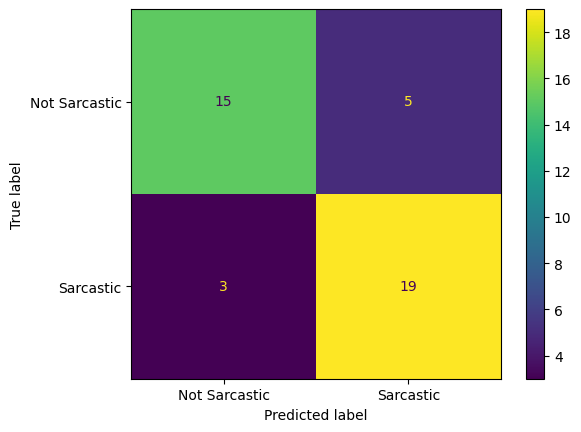

Statistics:
               precision    recall  f1-score   support

Not Sarcastic       0.83      0.75      0.79        20
    Sarcastic       0.79      0.86      0.83        22

     accuracy                           0.81        42
    macro avg       0.81      0.81      0.81        42
 weighted avg       0.81      0.81      0.81        42



In [61]:
# Weights
w_visual = 0.1
w_tone = 0.45
w_text = 0.45

# Value threshold - 50%
threshold = 0.50

num_rows = len(tone_predictions)

# Initialize lists to store the combined scores and predicted values
combined_scores = []
predicted_values = []
real_values = []

# Calculate combined scores and predicted values
for i in range(num_rows):
    combined_score = (w_tone * tone_predictions[i]) + (w_text * text_predictions[i]) + (w_visual * visual_predictions[i])
    combined_scores.append(combined_score)
    
    # Store the label value for that row, True if above the threshold
    predicted_value = combined_score > threshold
    predicted_values.append(predicted_value)
    


# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'combined_score': combined_scores,
    'predicted_value': [item for sublist in predicted_values for item in sublist],
    'real_value': test_df['sarcasm']
})

# print(results_df)

# Create and display confusion matrix
cm = confusion_matrix(results_df['real_value'].astype(int), results_df['predicted_value'].astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Sarcastic', 'Sarcastic'])
disp.plot()
plt.show()

# Create and display statistics
report = classification_report(results_df['real_value'].astype(int), results_df['predicted_value'].astype(int), target_names=['Not Sarcastic', 'Sarcastic'])

print("Statistics:")
print(report)